Example: Running the Stokes code to explore topographic decay on floating viscous sheets

The code requires FEniCS---see the README for details.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../source')

In [2]:
from main import solve
from params import H, Nx, Nz, rho_w, rho_i, t_e
from smb import smb_h, smb_s
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import convolve
import numpy as np
from params import t_r,t_f,nt,L
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [3]:
m0 = 1 / 3.154e7                # max basal melt(+) or freeze(-) rate (m/yr)
lamda = 25*H                    # wavelength of sinusoidal basal melt anomaly

Solve problem with small melt rate:

In [4]:
a = lambda x,t: smb_h(x,t,m0,lamda)
m = lambda x,t: smb_s(x,t,m0,lamda)

h,s,x = solve(a,m)

In [5]:
t = np.linspace(0,t_f, nt)

In [6]:
# # make a movie to make sure solution looks right...
# !rm -r movie
# !mkdir movie

# mpl.use('agg')

# ind = np.arange(0,t.size,5)
# j=0
# for i in ind:
#     plt.plot(x/H,h[:,i]-H,'k-')
#     plt.ylim(-4,4)
#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.ylabel(r'$h-H_0$',fontsize=20)
#     plt.xlabel(r'$x\,/\,H$',fontsize=20)
#     plt.tight_layout()
#     plt.savefig('./movie/'+str(j))
#     # plt.show()
#     plt.close()
#     j+=1

In [7]:
h_max = np.max(np.abs(h/H),axis=0) 

h_decay = h_max[t/t_e>4]
t_decay = t[t/t_e>4]
t_0 = t_decay[0]
t_decay -= t_0

func = lambda x, a, b, c: a * np.exp(-b * x) + c

y_data = h_decay
x_data = t_decay/t_e

popt, pcov = curve_fit(func, x_data, y_data)

a,b,c = popt

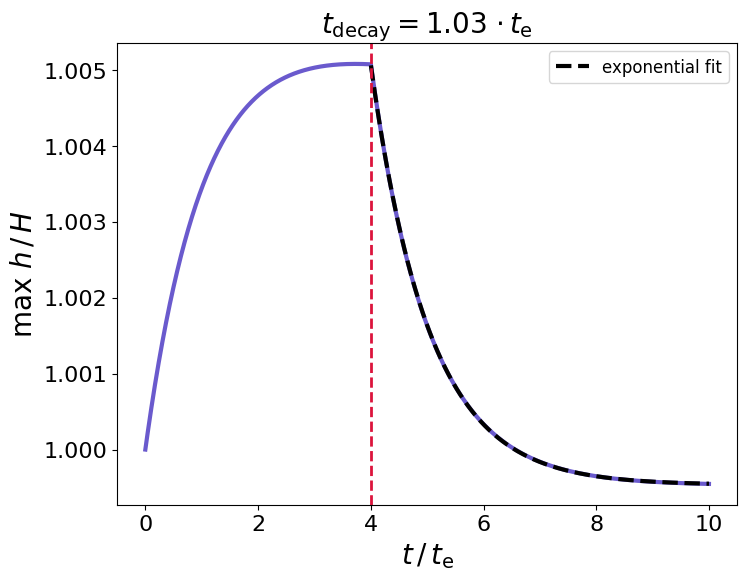

In [8]:
%matplotlib inline 
plt.figure(figsize=(8,6))
plt.title(r'$t_\mathrm{decay}=$'+'{:.2f}'.format(1/b)+r' $\cdot \,t_\mathrm{e}$' ,fontsize=20)
plt.plot(t/t_e,h_max,color='slateblue',linewidth=3)
plt.plot(x_data+t_0/t_e,func(x_data, a, b, c),color='k',linestyle='--',linewidth=3,label=r'exponential fit')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$t\,/\,t_\mathrm{e}$',fontsize=20)
plt.ylabel(r'max $h\,/\,H$',fontsize=20)
plt.axvline(x=t_0/t_e,linestyle='--',color='crimson',linewidth=2)
plt.annotate(xy=(t_0/t_e-1,0.0),text=r'turn off melt', fontsize=16,color='crimson',bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'))
plt.legend(fontsize=12)
plt.show()
plt.close()